In [136]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import skvideo.io
import os
import cv2

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import io
import imageio
import ipywidgets
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import backend as K

In [132]:
def frame_crop_center(video,cropf):
    f,_,_,_ = video.shape
    startf = f//2 - cropf//2
    return video[startf:startf+cropf, :, :, :]

fights=[]
nofights=[]

surv_fights=[]
surv_no_fights=[]

video_dims = []

####### Fight data
for filename in os.listdir(r'D:\python\video_transformer\fight-detection-surv-dataset\fight'):
    f = os.path.join(r'D:\python\video_transformer\fight-detection-surv-dataset\fight', filename)
    # checking if it is a file
    video = skvideo.io.vread(f)
    video_dims.append(video.shape)
    L=[]

    #resize video dimensions
    for i in range(video.shape[0]):
      frame = cv2.resize(video[i], (128,128), interpolation=cv2.INTER_CUBIC)
      L.append(frame)

    video = np.asarray(L)

    #center crop video to have consistent video frame number
    video = frame_crop_center(video, 42)

    surv_fights.append(video)

####### Fight data
for filename in os.listdir(r'D:\python\video_transformer\fight-detection-surv-dataset\noFight'):
    f = os.path.join(r'D:\python\video_transformer\fight-detection-surv-dataset\noFight', filename)
    # checking if it is a file
    video = skvideo.io.vread(f)
    video_dims.append(video.shape)
    L=[]

    #resize video dimensions
    for i in range(video.shape[0]):
      frame = cv2.resize(video[i], (128,128), interpolation=cv2.INTER_CUBIC)
      L.append(frame)

    video = np.asarray(L)

    #center crop video to have consistent video frame number
    video = frame_crop_center(video, 42)

    surv_no_fights.append(video)


In [133]:
data= pd.DataFrame(video_dims, columns=['frame_length', 'height', 'width', 'channels'])
data.describe()

,frame_length,height,width,channels
count,300.000000,300.000000,300.000000,300.0
mean,57.066667,467.466667,789.006667,3.0
std,15.932830,200.530556,383.065386,0.0
min,20.000000,216.000000,320.000000,3.0
25%,50.000000,360.000000,480.000000,3.0
50%,60.000000,360.000000,640.000000,3.0
75%,60.000000,720.000000,1280.000000,3.0
max,142.000000,1080.000000,1920.000000,3.0


In [134]:
surv_fights = [video for video in surv_fights if video.shape[0] == 42]
surv_no_fights = [video for video in surv_no_fights if video.shape[0] == 42]
videos = surv_fights+surv_no_fights
videos = np.asarray(videos)

labels = np.concatenate([np.ones(len(surv_fights)), np.zeros(len(surv_no_fights)) ])


In [135]:
print(videos.shape)

(260, 42, 128, 128, 3)


In [137]:
X_train, X_test, y_train, y_test = train_test_split(videos, labels, test_size=0.2, random_state=2334)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=124567)

In [138]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(187, 42, 128, 128, 3)
(21, 42, 128, 128, 3)
(52, 42, 128, 128, 3)


In [153]:
# Setting seed for reproducibility
SEED = 77
os.environ["TF_CUDNN_DETERMINISTIC"] = "1"
tf.random.set_seed(SEED)

# DATA
DATASET_NAME = "fight/nofights"
BATCH_SIZE = 4
AUTO = tf.data.AUTOTUNE
INPUT_SHAPE = (42, 128, 128, 3)
NUM_CLASSES = 2

# OPTIMIZER
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-5

# TRAINING
EPOCHS = 20

# TUBELET EMBEDDING
PATCH_SIZE = (8, 8, 8)
NUM_PATCHES = (INPUT_SHAPE[0] // PATCH_SIZE[0]) ** 2

# ViViT ARCHITECTURE
LAYER_NORM_EPS = 1e-6
PROJECTION_DIM = 64
NUM_HEADS = 2
NUM_LAYERS = 2

Preprocess and prepare dataloader


In [154]:
@tf.function
def preprocess(frames: tf.Tensor, label: tf.Tensor):
    """Preprocess the frames tensors and parse the labels"""
    # Preprocess images
    frames = tf.image.convert_image_dtype(
        frames[
            ..., tf.newaxis
        ],  # The new axis is to help for further processing with Conv3D layers
        tf.float32,
    )

    # Parse label
    label = tf.cast(label, tf.float32)
    return frames, label


def prepare_dataloader(
    videos: np.ndarray,
    labels: np.ndarray,
    loader_type: str = "train",
    batch_size: int = BATCH_SIZE,
):
    """Utility function to prepare dataloader"""
    dataset = tf.data.Dataset.from_tensor_slices((videos, labels))

    if loader_type == "train":
        dataset = dataset.shuffle(BATCH_SIZE * 2)

    dataloader = (
        dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
        .batch(batch_size)
        .prefetch(tf.data.AUTOTUNE)
    )

    return dataloader


trainloader = prepare_dataloader(X_train, y_train, "train")
validloader = prepare_dataloader(X_val, y_val, "valid")
testloader = prepare_dataloader(X_test, y_test, "test")

Define some model classes¶


In [155]:
class TubeletEmbedding(layers.Layer):
    def __init__(self, embed_dim, patch_size, **kwargs):
        super().__init__(**kwargs)
        self.projection = layers.Conv3D(
            filters=embed_dim,
            kernel_size=patch_size,
            strides=patch_size,
            padding="VALID",
        )
        self.flatten = layers.Reshape(target_shape=(-1, embed_dim))

    def call(self, videos):
        projected_patches = self.projection(videos)
        flattened_patches = self.flatten(projected_patches)
        return flattened_patches

class PositionalEncoder(layers.Layer):
    def __init__(self, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim

    def build(self, input_shape):
        _, num_tokens, _ = input_shape
        self.position_embedding = layers.Embedding(
            input_dim=num_tokens, output_dim=self.embed_dim
        )
        self.positions = tf.range(start=0, limit=num_tokens, delta=1)

    def call(self, encoded_tokens):
        # Encode the positions and add it to the encoded tokens
        encoded_positions = self.position_embedding(self.positions)
        encoded_tokens = encoded_tokens + encoded_positions
        return encoded_tokens

Create model¶


In [156]:
def create_vivit_classifier(
    tubelet_embedder,
    positional_encoder,
    input_shape=INPUT_SHAPE,
    transformer_layers=NUM_LAYERS,
    num_heads=NUM_HEADS,
    embed_dim=PROJECTION_DIM,
    layer_norm_eps=LAYER_NORM_EPS,
    num_classes=NUM_CLASSES,
):
    # Get the input layer
    inputs = layers.Input(shape=input_shape)
    # Create patches.
    patches = tubelet_embedder(inputs)
    # Encode patches.
    encoded_patches = positional_encoder(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization and MHSA
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim // num_heads, dropout=0.1
        )(x1, x1)

        # Skip connection
        x2 = layers.Add()([attention_output, encoded_patches])

        # Layer Normalization and MLP
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = keras.Sequential(
            [
                layers.Dense(units=embed_dim * 4, activation=tf.nn.gelu),
                layers.Dense(units=embed_dim, activation=tf.nn.gelu),
            ]
        )(x3)

        # Skip connection
        encoded_patches = layers.Add()([x3, x2])

    # Layer normalization and Global average pooling.
    representation = layers.LayerNormalization(epsilon=layer_norm_eps)(encoded_patches)
    representation = layers.GlobalAvgPool1D()(representation)

    # Classify outputs.
    outputs = layers.Dense(units=num_classes, activation="softmax")(representation)

    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

Define metrics, build, train and save ViVit model


In [157]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def run_experiment():
    # Initialize model
    model = create_vivit_classifier(
        tubelet_embedder=TubeletEmbedding(
            embed_dim=PROJECTION_DIM, patch_size=PATCH_SIZE
        ),
        positional_encoder=PositionalEncoder(embed_dim=PROJECTION_DIM),
    )

    # Compile the model with the optimizer, loss function
    # and the metrics.
    optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    model.compile(
        optimizer=optimizer,
        loss="sparse_categorical_crossentropy",
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            recall_m,
            precision_m,
            f1_m,
        ],
    )

    # Train the model.
    _ = model.fit(trainloader, epochs=EPOCHS, validation_data=validloader)

    _, accuracy, recall, precision, f1 = model.evaluate(testloader)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test recall: {round(recall * 100, 2)}%")
    print(f"Test precision: {round(precision * 100, 2)}%")
    print(f"Test F1: {round(f1 * 100, 2)}%")

    vivit_scores = [accuracy, recall, precision, f1]
    return model, vivit_scores


model, vivit_scores = run_experiment()

model.save('vivit_model')

Epoch 1/20
47/47 [==============================] - 20s 379ms/step - loss: 0.8006 - accuracy: 0.4706 - recall_m: 0.9574 - precision_m: 0.5426 - f1_m: 0.6721 - val_loss: 0.7059 - val_accuracy: 0.3810 - val_recall_m: 1.0000 - val_precision_m: 0.5833 - val_f1_m: 0.7095
Epoch 2/20
47/47 [==============================] - 17s 366ms/step - loss: 0.7182 - accuracy: 0.5027 - recall_m: 0.9787 - precision_m: 0.5461 - f1_m: 0.6746 - val_loss: 0.7339 - val_accuracy: 0.5714 - val_recall_m: 1.0000 - val_precision_m: 0.5833 - val_f1_m: 0.7095
Epoch 3/20
47/47 [==============================] - 17s 366ms/step - loss: 0.7245 - accuracy: 0.5134 - recall_m: 0.9574 - precision_m: 0.5426 - f1_m: 0.6752 - val_loss: 0.7204 - val_accuracy: 0.4762 - val_recall_m: 1.0000 - val_precision_m: 0.5833 - val_f1_m: 0.7095
Epoch 4/20
47/47 [==============================] - 17s 364ms/step - loss: 0.7203 - accuracy: 0.4599 - recall_m: 0.9362 - precision_m: 0.5443 - f1_m: 0.6696 - val_loss: 0.7075 - val_accuracy: 0.4762 

INFO:tensorflow:Assets written to: vivit_model\assets


INFO:tensorflow:Assets written to: vivit_model\assets


13/13 [==============================] - 2s 104ms/step


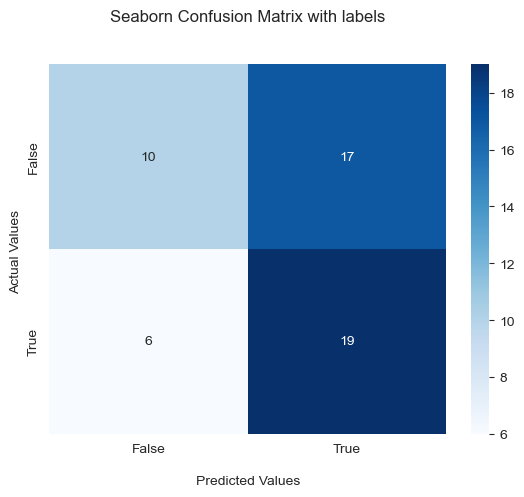

In [144]:
y_preds = np.argmax(model.predict(testloader), axis=1)

#Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, y_preds)

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()
ax.figure.savefig("vivit_cf.png")

In [147]:
NUM_SAMPLES_VIZ = 25

testsamples, labels_ = next(iter(testloader))
testsamples, labels_ = X_test[:NUM_SAMPLES_VIZ], y_test[:NUM_SAMPLES_VIZ]

ground_truths = []
preds = []
videos_ = []

for i, (testsample, label) in enumerate(zip(testsamples, labels_)):
    # Generate gif
    with io.BytesIO() as gif:
        imageio.mimsave(gif, (testsample * 255).astype("uint8"), "GIF", duration=20)
        videos_.append(gif.getvalue())

    # Get model prediction
    output = model.predict(tf.expand_dims(testsample, axis=0))[0]
    pred = np.argmax(output, axis=0)

    ground_truths.append(label.astype("int"))
    preds.append(pred)


def make_box_for_grid(image_widget, fit):
    """Make a VBox to hold caption/image for demonstrating option_fit values.

    Source: https://ipywidgets.readthedocs.io/en/latest/examples/Widget%20Styling.html
    """
    # Make the caption
    if fit is not None:
        fit_str = "'{}'".format(fit)
    else:
        fit_str = str(fit)

    h = ipywidgets.HTML(value="" + str(fit_str) + "")

    # Make the green box with the image widget inside it
    boxb = ipywidgets.widgets.Box()
    boxb.children = [image_widget]

    # Compose into a vertical box
    vb = ipywidgets.widgets.VBox()
    vb.layout.align_items = "center"
    vb.children = [h, boxb]
    return vb


boxes = []
label_dict = {0: 'noFight', 1: 'Fight'}
for i in range(NUM_SAMPLES_VIZ):
    ib = ipywidgets.widgets.Image(value=videos_[i], width=200, height=200)
    true_class = label_dict[ground_truths[i]]
    pred_class = label_dict[preds[i]]
    caption = f"T: {true_class} | P: {pred_class}"

    boxes.append(make_box_for_grid(ib, caption))

ipywidgets.widgets.GridBox(
    boxes, layout=ipywidgets.widgets.Layout(grid_template_columns="repeat(5, 200px)")
)


1/1 [==============================] - 0s 32ms/step


GridBox(children=(VBox(children=(HTML(value="'T: Fight | P: noFight'"), Box(children=(Image(value=b'GIF89a\x80…